<a href="https://colab.research.google.com/github/Karthik982018/Karthik982018/blob/main/Centralised_learning_COMP702.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install  -q kaggle


In [ ]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"karthik982018","key":"c4a9ad5dea2afb7a230c0daa9d980719"}'}

In [ ]:
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets download -d andrewmvd/lung-and-colon-cancer-histopathological-images
!unzip lung-and-colon-cancer-histopathological-images.zip

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import os

import tensorflow as tf
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator



from tensorflow import keras
from keras import layers
from keras.layers import Dense, Conv2D, MaxPool2D , Flatten, Dropout, Activation

from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
import seaborn as sns
from tensorflow.keras.callbacks import EarlyStopping

In [ ]:
print(tf.__version__)

2.8.2


In [ ]:
data_dir="/content/lung_colon_image_set/lung_image_sets"

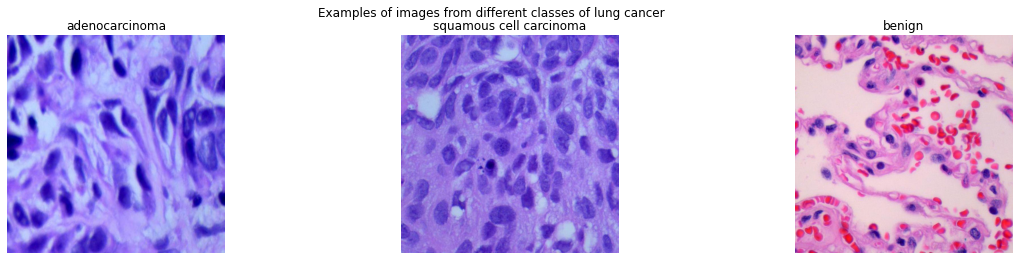

In [ ]:
examples = (
    ('lung_aca', 'lungaca1914.jpeg'),
    ('lung_scc', 'lungscc1930.jpeg'),
    ('lung_n', 'lungn691.jpeg')
)

filenames = tuple(os.path.join(data_dir, *path) for path in examples)
titles = ('adenocarcinoma', 'squamous cell carcinoma', 'benign') 

fig, axs = plt.subplots(1, 3)
fig.set_figwidth(20)
fig.suptitle('Examples of images from different classes of lung cancer')

for imgname, title, ax in zip(filenames, titles, axs.flatten()):
    ax.imshow(image.load_img(imgname))
    ax.axis('off')
    ax.set_title(title)
plt.show()

In [ ]:
data = ImageDataGenerator(validation_split = 0.2)

train_data_centralised = data.flow_from_directory(data_dir,
                                    class_mode = "categorical",
                                    target_size = (224,224),
                                    color_mode="rgb",
                                    batch_size = 15,
                                    shuffle = False,
                                    subset='training',
                                    seed = 42)

validation_data_centralised = data.flow_from_directory(data_dir,
                                      class_mode = "categorical",
                                      target_size = (224, 224),
                                      color_mode="rgb",
                                      batch_size = 15, 
                                      shuffle = False,
                                      subset='validation',
                                      seed = 42)

Found 12000 images belonging to 3 classes.
Found 3000 images belonging to 3 classes.


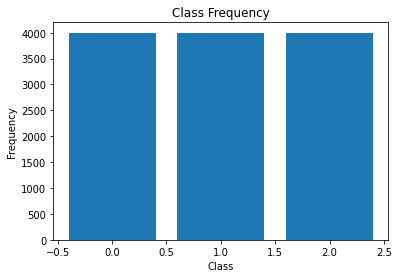

In [ ]:
unique, counts = np.unique(train_data_centralised.classes, return_counts=True)
plt.bar(unique, counts)


plt.title('Class Frequency')
plt.xlabel('Class')
plt.ylabel('Frequency')

plt.show()

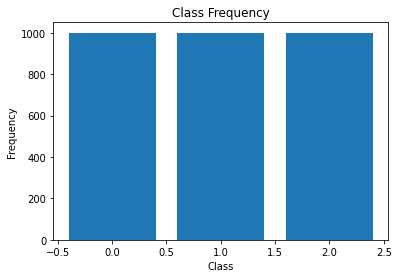

In [ ]:
unique, counts = np.unique(validation_data_centralised.classes, return_counts=True)
plt.bar(unique, counts)

plt.title('Class Frequency')
plt.xlabel('Class')
plt.ylabel('Frequency')

plt.show()

In [ ]:
def plot_training(history):
  plt.plot(history.history['accuracy'])
  plt.plot(history.history['val_accuracy'])
  plt.title('Training accuracy')
  plt.ylabel('Training accuracy')
  plt.xlabel('Epoch')
  plt.legend(['Train', 'Validation'], loc='upper right')
  plt.show()


  plt.plot(history.history['loss'])
  plt.plot(history.history['val_loss'])
  plt.title('Training loss')
  plt.ylabel('Loss')
  plt.xlabel('Epoch')
  plt.legend(['Train', 'Validation'], loc='upper right')
  plt.show()

In [ ]:
def plot_classification_report(model):
  Y_pred = model.predict(validation_data_centralised)
  y_pred = np.argmax(Y_pred, axis=1)

  print(classification_report( validation_data_centralised.classes,y_pred))
  return y_pred


In [ ]:
def plot_confusion_matrix(pred,classes):
  cf_matrix = confusion_matrix(classes, pred)

  ax = sns.heatmap(cf_matrix, annot=True, cmap='Blues')

  ax.set_title('Confusion Matrix\n\n');
  ax.set_xlabel('\nPredicted ')
  ax.set_ylabel('Actual');

  ## Ticket labels - List must be in alphabetical order
  ax.xaxis.set_ticklabels(['lung_aca', 'lung_n', 'lung_scc'])
  ax.yaxis.set_ticklabels(['lung_aca', 'lung_n', 'lung_scc'])

  ## Display the visualization of the Confusion Matrix.
  plt.show()
  



**Centralised learning**



In [ ]:
early_stopping = EarlyStopping(monitor='val_loss', patience=3)

In [ ]:
optim = tf.keras.optimizers.Adam()

**VGG16**

In [ ]:
from keras.applications.vgg16 import VGG16

In [ ]:
vgg16=VGG16(input_shape=(224,224,3),
                             include_top=False,
                             weights='imagenet')

58900480/58889256 [==============================] - 0s 0us/step


In [ ]:
vgg16.trainable=False

In [ ]:
x = Conv2D(filters=512, kernel_size=(3,3), padding='same', activation='relu', name='newConv_vgg16')(vgg16.output)
x = MaxPool2D(pool_size=(2,2), strides=(2,2), padding='valid', name='new_pool_vgg16')(x)
x = keras.layers.Flatten()(x)
x = keras.layers.Dense(256, activation='relu')(x)
x = Dropout(0.7, name='newDropout_1vgg16')(x)
x = keras.layers.Dense(256, activation='relu')(x)
x = Dropout(0.7, name='newDropout_2vgg16')(x)
x = keras.layers.Dense(100, activation='relu')(x)
x=layers.Dense(3,activation='softmax', name = 'classifier')(x)
vgg16_modified=keras.Model(vgg16.input,x)

In [ ]:
vgg16_modified.compile(optimizer=optim,
              loss='categorical_crossentropy',
               metrics=['accuracy'])

In [ ]:
history_vgg16 =vgg16_modified.fit(train_data_centralised,validation_data=validation_data_centralised,epochs=20,verbose=1,callbacks=[early_stopping])

Epoch 1/20
800/800 [==============================] - 136s 153ms/step - loss: 1.1245 - accuracy: 0.8087 - val_loss: 0.1125 - val_accuracy: 0.9587
Epoch 2/20
800/800 [==============================] - 121s 151ms/step - loss: 0.1825 - accuracy: 0.9469 - val_loss: 0.0985 - val_accuracy: 0.9607
Epoch 3/20
800/800 [==============================] - 121s 151ms/step - loss: 0.1684 - accuracy: 0.9548 - val_loss: 0.0867 - val_accuracy: 0.9660
Epoch 4/20
800/800 [==============================] - 120s 150ms/step - loss: 0.0928 - accuracy: 0.9702 - val_loss: 0.1021 - val_accuracy: 0.9670
Epoch 5/20
800/800 [==============================] - 120s 150ms/step - loss: 0.0925 - accuracy: 0.9754 - val_loss: 0.1009 - val_accuracy: 0.9730
Epoch 6/20
800/800 [==============================] - 121s 151ms/step - loss: 0.0693 - accuracy: 0.9813 - val_loss: 0.1228 - val_accuracy: 0.9597


In [ ]:
test3=vgg16_modified.evaluate(validation_data_centralised)

200/200 [==============================] - 24s 119ms/step - loss: 0.1228 - accuracy: 0.9597


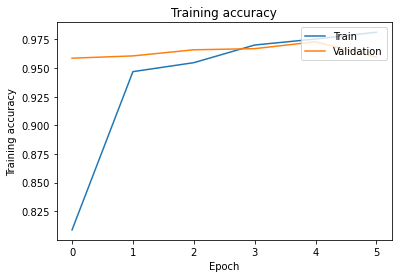

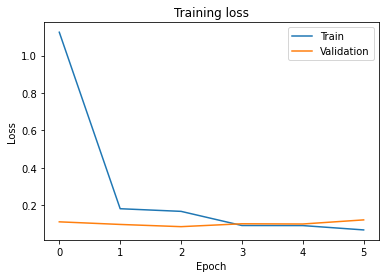

In [ ]:
plot_training(history_vgg16)

In [ ]:
pred2=plot_classification_report(vgg16_modified)

              precision    recall  f1-score   support

           0       0.99      0.89      0.94      1000
           1       0.99      1.00      0.99      1000
           2       0.91      0.99      0.95      1000

    accuracy                           0.96      3000
   macro avg       0.96      0.96      0.96      3000
weighted avg       0.96      0.96      0.96      3000



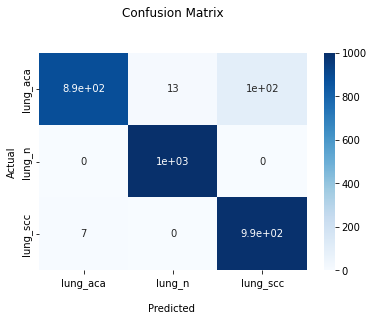

In [ ]:
plot_confusion_matrix(pred2,validation_data_centralised.classes)

In [ ]:
vgg16_modified.save("vgg16f.h5")

In [ ]:
loaded_model=tf.keras.models.load_model("vgg16f.h5")

**VGG19**

In [ ]:
from keras.applications.vgg19 import VGG19

In [ ]:
vgg19=VGG19(input_shape=(224,224,3),
                             include_top=False,
                             weights='imagenet')

80150528/80134624 [==============================] - 2s 0us/step


In [ ]:
vgg19.trainable=False

In [ ]:
x = Conv2D(filters=512, kernel_size=(3,3), padding='same', activation='relu', name='newConv_vgg19')(vgg19.output)
x = MaxPool2D(pool_size=(2,2), strides=(2,2), padding='valid', name='new_pool_VGG19')(x)
x = keras.layers.Flatten()(x)
x = keras.layers.Dense(256, activation='relu')(x)
x = Dropout(0.7, name='newDropout_1VGG19')(x)
x = keras.layers.Dense(256, activation='relu')(x)
x = Dropout(0.7, name='newDropout_2VGG19')(x)
x = keras.layers.Dense(100, activation='relu')(x)
x=layers.Dense(3,activation='softmax', name = 'classifier')(x)
vgg19_modified=keras.Model(vgg19.input,x)

In [ ]:
vgg19_modified.compile(optimizer=optim,
              loss='categorical_crossentropy',
               metrics=['accuracy'])

In [ ]:
history_vgg19=vgg19_modified.fit(train_data_centralised,validation_data=validation_data_centralised,epochs=20,verbose=1,callbacks=[early_stopping])

Epoch 1/20
800/800 [==============================] - 127s 144ms/step - loss: 1.0775 - accuracy: 0.7868 - val_loss: 0.1508 - val_accuracy: 0.9450
Epoch 2/20
800/800 [==============================] - 115s 144ms/step - loss: 0.2217 - accuracy: 0.9306 - val_loss: 0.1613 - val_accuracy: 0.9443
Epoch 3/20
800/800 [==============================] - 115s 144ms/step - loss: 0.1845 - accuracy: 0.9490 - val_loss: 0.0875 - val_accuracy: 0.9700
Epoch 4/20
800/800 [==============================] - 114s 143ms/step - loss: 0.1549 - accuracy: 0.9568 - val_loss: 0.0961 - val_accuracy: 0.9687
Epoch 5/20
800/800 [==============================] - 114s 143ms/step - loss: 0.1206 - accuracy: 0.9697 - val_loss: 0.1330 - val_accuracy: 0.9690
Epoch 6/20
800/800 [==============================] - 115s 143ms/step - loss: 0.1143 - accuracy: 0.9660 - val_loss: 0.1170 - val_accuracy: 0.9647


In [ ]:
test2=vgg19_modified.evaluate(validation_data_centralised)

200/200 [==============================] - 23s 116ms/step - loss: 0.1170 - accuracy: 0.9647


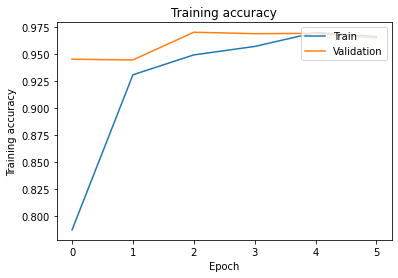

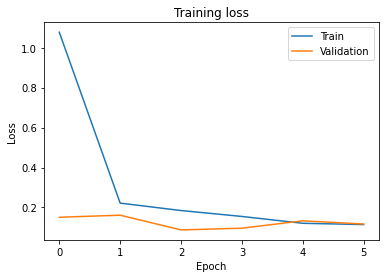

In [ ]:
plot_training(history_vgg19)

In [ ]:
pred=plot_classification_report(vgg19_modified)

              precision    recall  f1-score   support

           0       0.92      0.98      0.95      1000
           1       1.00      0.99      0.99      1000
           2       0.98      0.93      0.95      1000

    accuracy                           0.96      3000
   macro avg       0.97      0.96      0.96      3000
weighted avg       0.97      0.96      0.96      3000



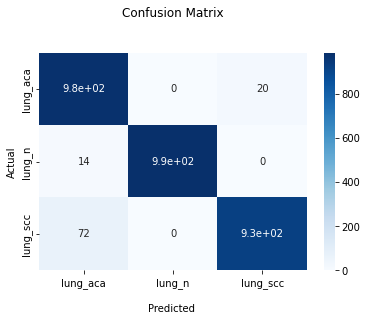

In [ ]:
plot_confusion_matrix(pred,validation_data_centralised.classes)

In [ ]:
vgg19_modified.save("vgg19f.h5")

In [ ]:
loaded_model1=tf.keras.models.load_model("vgg19f.h5")

**Resnet50**

In [ ]:
from tensorflow.keras.applications.resnet50 import ResNet50

In [ ]:
resnet50=ResNet50(input_shape=(224,224,3),
                             include_top=False,
                             weights='imagenet')

94781440/94765736 [==============================] - 1s 0us/step


In [ ]:
resnet50.trainable=False

In [ ]:
x = Conv2D(filters=512, kernel_size=(3,3), padding='same', activation='relu', name='newConv_resnet50')(resnet50.output)
x = MaxPool2D(pool_size=(2,2), strides=(2,2), padding='valid', name='new_pool_resnet50')(x)
x = keras.layers.Flatten()(x)
x = keras.layers.Dense(256, activation='relu')(x)
x = Dropout(0.7, name='newDropout_1resnet50')(x)
x = keras.layers.Dense(256, activation='relu')(x)
x = Dropout(0.7, name='newDropout_2resnet50')(x)
x = keras.layers.Dense(100, activation='relu')(x)
x=layers.Dense(3,activation='softmax', name = 'classifier')(x)
resnet50_modified=keras.Model(resnet50.input,x)

In [ ]:
resnet50_modified.compile(optimizer = optim,
              loss='categorical_crossentropy',
               metrics=['accuracy'])

In [ ]:
history_restnet50=resnet50_modified.fit(train_data_centralised,validation_data=validation_data_centralised,epochs=20,verbose=1,callbacks=[early_stopping])

Epoch 1/20
800/800 [==============================] - 148s 166ms/step - loss: 0.7161 - accuracy: 0.8210 - val_loss: 0.4336 - val_accuracy: 0.8620
Epoch 2/20
800/800 [==============================] - 130s 163ms/step - loss: 0.1363 - accuracy: 0.9548 - val_loss: 0.0944 - val_accuracy: 0.9600
Epoch 3/20
800/800 [==============================] - 130s 162ms/step - loss: 0.1626 - accuracy: 0.9566 - val_loss: 0.0672 - val_accuracy: 0.9767
Epoch 4/20
800/800 [==============================] - 129s 162ms/step - loss: 0.0642 - accuracy: 0.9793 - val_loss: 0.0539 - val_accuracy: 0.9823
Epoch 5/20
800/800 [==============================] - 129s 162ms/step - loss: 0.0927 - accuracy: 0.9747 - val_loss: 0.0730 - val_accuracy: 0.9737
Epoch 6/20
800/800 [==============================] - 130s 162ms/step - loss: 0.0372 - accuracy: 0.9873 - val_loss: 0.0448 - val_accuracy: 0.9857
Epoch 7/20
800/800 [==============================] - 129s 161ms/step - loss: 0.0398 - accuracy: 0.9882 - val_loss: 1.3824 -

In [ ]:
test1=resnet50_modified.evaluate(validation_data_centralised)

200/200 [==============================] - 26s 131ms/step - loss: 0.0666 - accuracy: 0.9810


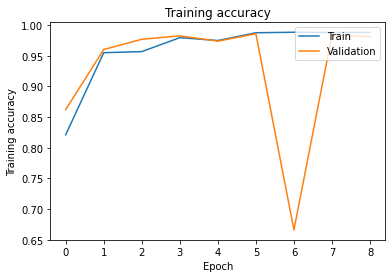

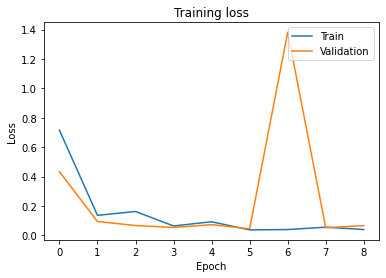

In [ ]:
plot_training(history_restnet50)

In [ ]:
pred1=plot_classification_report(resnet50_modified)

              precision    recall  f1-score   support

           0       0.99      0.95      0.97      1000
           1       0.99      1.00      1.00      1000
           2       0.96      0.99      0.98      1000

    accuracy                           0.98      3000
   macro avg       0.98      0.98      0.98      3000
weighted avg       0.98      0.98      0.98      3000



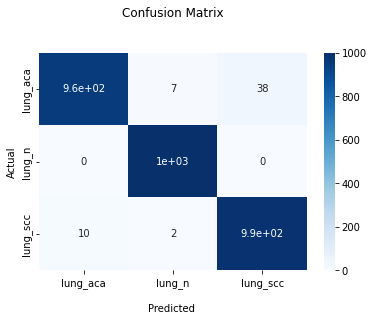

In [ ]:
plot_confusion_matrix(pred1,validation_data_centralised.classes)

In [ ]:
resnet50_modified.save("resnet50.h5")

In [ ]:
loaded_model2=tf.keras.models.load_model("resnet50.h5")